# 5.0 - SOTA evaluation

Although we were given a dataset corresponding to [this paper](https://aclanthology.org/2021.emnlp-main.629/). There is a continuation of the work of this team [here](https://aclanthology.org/2022.acl-long.469) where they introduce `bart-base-detox` model for detoxification. In the paper they conclude that it is a new SOTA.

I will evaluate on the same input data model of their team for further comparison in report.


In [1]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text2text-generation", model="s-nlp/bart-base-detox")

/home/leo/github.com/lvjonok/f23-pmldl/f23-pmldl-assignment1/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load model to evaluate toxicity

In [4]:
from transformers import pipeline

# load metrics
import evaluate

# Load the BLUE metric
metric = evaluate.load("sacrebleu")

# load toxicity rate metric
toxicity_rater = pipeline("text-classification", model="martin-ha/toxic-comment-model")

## Load dataset for evaluation

In [3]:
import pandas as pd

# load validation dataset
df = pd.read_csv("../data/interim/val.csv", index_col=0)

df.head()

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
Unnamed: 0,,,,,,
391689,"You're smaller than I thought you'd be, which ...","you're shorter than I expected, which is odd, ...",0.721598,0.064748,0.998819,0.028113
444152,I bet it's your favorite secret jerk-off movie.,I bet there's a secret joke in that movie.,0.741154,0.104167,0.990315,0.000071
542359,Your fucking gangster brother Michael!,your Nigerian brother Michael!,0.808982,0.205128,0.999699,0.000110
215791,"McMurphy... ...get your ass over here,and brin...","McMurphy, come here and take Dracula with you.",0.756882,0.287879,0.999087,0.018837
308611,Alexis injected it directly into the body of a...,Alexis injected her directly into the body.,0.895725,0.200000,0.947276,0.015108


In [7]:
def evaluate(sentence):
    """
    evaluate is a helper function which computes bleu score and toxicity rate
    after sentence transformation
    """
    result = pipe(sentence)[0]["generated_text"]

    # compute bleu score
    bleu_score = metric.compute(predictions=[result], references=[sentence])["score"]

    # compute toxicity rate
    toxicity = toxicity_rater(result)[0]

    return {
        "sentence": result,
        "bleu_score": bleu_score,
        "toxicity": toxicity,
        "rate": toxicity["score"] * (-1 if toxicity["label"] == "toxic" else 1),
    }


evaluate("I bet it's bullshit favorite secret jerk-off movie.")

/home/leo/github.com/lvjonok/f23-pmldl/f23-pmldl-assignment1/venv/lib/python3.10/site-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


{'sentence': "I bet it's favorite secret movie",
 'bleu_score': 24.117803988461304,
 'toxicity': {'label': 'non-toxic', 'score': 0.9988685846328735},
 'rate': 0.9988685846328735}

In [8]:
from tqdm import tqdm

history = []

for sentence in tqdm(df.sample(500)["reference"]):
    history.append(evaluate(sentence))

100%|██████████| 500/500 [08:44<00:00,  1.05s/it]


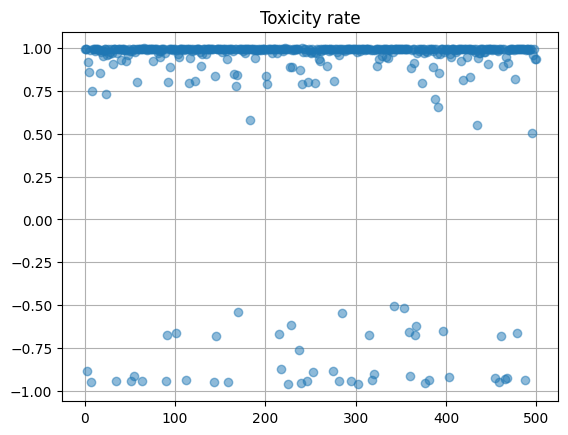

In [9]:
import matplotlib.pyplot as plt

plt.title("Toxicity rate")
plt.plot([h["rate"] for h in history], marker="o", linestyle="None", alpha=0.5)
plt.grid()

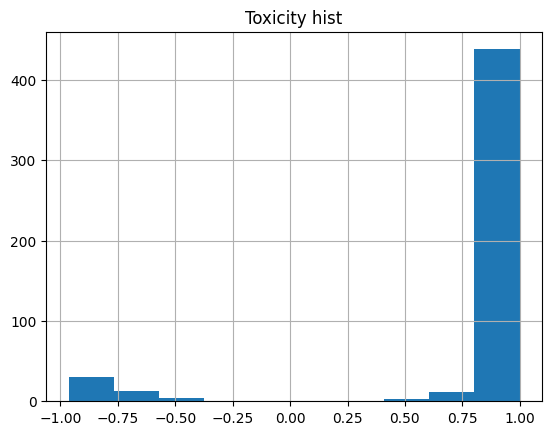

In [10]:
plt.title("Toxicity hist")
plt.hist([h["rate"] for h in history])
plt.grid()

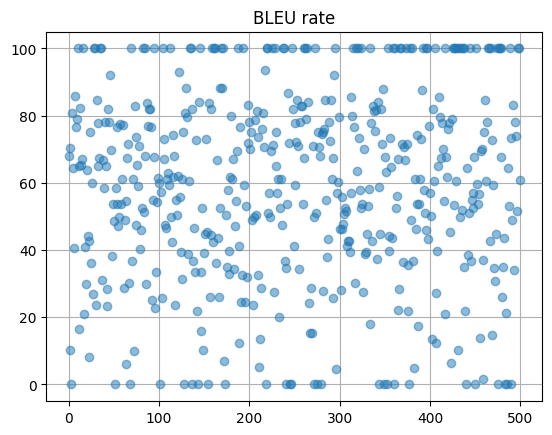

In [11]:
import matplotlib.pyplot as plt

plt.title("BLEU rate")
plt.plot([h["bleu_score"] for h in history], marker="o", linestyle="None", alpha=0.5)
plt.grid()

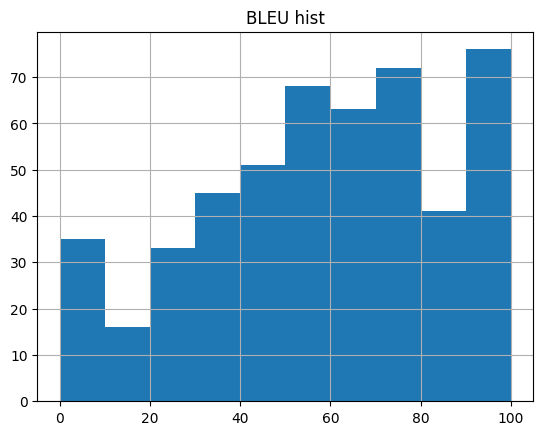

In [12]:
plt.title("BLEU hist")
plt.hist([h["bleu_score"] for h in history])
plt.grid()